In [1]:
%matplotlib inline

In [18]:
import matplotlib.pyplot as plt

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [181]:
Calpha = fp.Variable(0.05, name=r"$C_\alpha$")
Cbeta = fp.Variable(0.95, name=r"$C_\beta$")
Cm = (Calpha + Cbeta) / 2.
Cm.name = "$C_m$"
A = fp.Variable(2.0, name="A")
B = A / (Calpha - Cm)**2
B.name = "B"
gamma = 2. / (Cbeta - Calpha)**2
gamma.name = r"$\gamma$"
beta = fp.Variable(1.0, name=r"$\beta$")
Dalpha = gamma / beta**2
Dalpha.name = r"$D_\alpha$"
Dbeta = gamma / beta**2
Dbeta.name = r"$D_\beta$"
epsilonij = fp.Variable(3.0, name=r"$\epsilon_{ij}$")
kappai = fp.Variable(2.0, name=r"$\kappa_i$")
kappaC = fp.Variable(2.0, name=r"$\kappa_C$")
D = fp.Variable(1.0, name="D")
Li = fp.Variable(1.0, name="$L_i$")

In [349]:
N = 200
mesh = fp.Grid1D(nx=N)

In [350]:
C = fp.CellVariable(mesh=mesh, name="C", hasOld=True)

In [351]:
eta = [fp.CellVariable(mesh=mesh, name=r"$\eta_{i}$".format(i=i+1), hasOld=True) for i in range(1)]

In [352]:
f1 = -(A/2)*(C - Cm)**2 + (B/4)*(C - Cm)**4 + (Dalpha/4)*(C - Calpha)**4 + (Dbeta/4)*(C - Cbeta)**4
f1.name = "$f_1$"

f2 = []
for i, etai in enumerate(eta):
    f2i = -(gamma/2)*(C - Calpha)**2 * etai**2 + (beta/4)*etai**4
    f2i.name = "$f_{{2{i}}}$".format(i=i+1)
    f2.append(f2i)

f3 = []
for i, etai in enumerate(eta):
    f3i = []
    for j, etaj in enumerate(eta):
        if etaj is not etai:
            f3ij = (epsilonij/2) * etai**2 * etaj**2 
            f3ij.name = "$f_{{3{i}{j}}}$".format(i=i+1, j=j+1)
        else:
            f3ij = None
        f3i.append(f3ij)
    f3.append(f3i)
    
f0 = f1
for f2i in f2:
    f0 += f2i
for f3i in f3:
    for f3ij in f3i:
        if f3ij is not None:
            f0 += f3ij
f0.name = "$f_0$"

In [353]:
f = f0 + (kappaC/2.)*(C.grad.mag)**2
for etai in eta:
    f += (kappai/2.)*(etai.grad.mag)**2
f.name = "f"

In [354]:
Cf = C.arithmeticFaceValue
Cf.name = "C"
eqC = (fp.TransientTerm(coeff=1., var=C)
       == fp.DiffusionTerm(coeff=D*(-A + 3*B*(Cf - Cm)**2 
                                    + 3*Dalpha*(Cf - Calpha)**2 
                                    + 3*Dbeta*(Cf - Cbeta)**2), var=C)
       - fp.DiffusionTerm(coeff=(D,kappaC), var=C))
for etai in eta:
    eqC += fp.DiffusionTerm(coeff=D*gamma*etai**2, var=C)
    eqC += fp.DiffusionTerm(coeff=2*D*gamma*(Cf-Calpha), var=etai)
#    eqC += (fp.ConvectionTerm(coeff=2*D*gamma*etai.faceGrad, var=C) 
#            - (2*D*gamma*Calpha*etai.faceGrad).divergence)

In [355]:
eq_eta = []
for etai in eta:
    eqi = (fp.TransientTerm(coeff=1., var=etai)
           == fp.ImplicitSourceTerm(coeff=Li*gamma*(C-Calpha)*etai, var=C)
           - fp.ImplicitSourceTerm(coeff=Li*gamma*(C-Calpha)*Calpha, var=etai)
           - fp.ImplicitSourceTerm(coeff=Li*beta*etai**2, var=etai)
           + fp.DiffusionTerm(coeff=Li*kappai, var=etai))
    for etaj in eta:
        if etaj is not etai:
            eqi += fp.ImplicitSourceTerm(coeff=Li*epsilonij*etaj**2, var=etai)
    eq_eta.append(eqi)

In [356]:
eq_eta = []
for etai in eta:
    eqi = (fp.TransientTerm(coeff=1., var=etai)
           == fp.ImplicitSourceTerm(coeff=Li*gamma*(C-Calpha)**2, var=etai)
           - fp.ImplicitSourceTerm(coeff=Li*beta*etai**2, var=etai)
           + fp.DiffusionTerm(coeff=Li*kappai, var=etai))
    for etaj in eta:
        if etaj is not etai:
            eqi += fp.ImplicitSourceTerm(coeff=Li*epsilonij*etaj**2, var=etai)
    eq_eta.append(eqi)

In [357]:
eq_eta[0]

(TransientTerm(coeff=1.0, var=$\eta_1$) + ((ImplicitSourceTerm(coeff=-(((pow((C - $C_\alpha$), 2)) * ($L_i$ * $\gamma$))), var=$\eta_1$) + ImplicitSourceTerm(coeff=-(-(((pow($\eta_1$, 2)) * ($L_i$ * $\beta$)))), var=$\eta_1$)) + DiffusionTerm(coeff=[-(($L_i$ * $\kappa_i$))], var=$\eta_1$)))

In [236]:
eq = eqC
for eq_etai in eq_eta:
    eq &= eq_etai

In [237]:
phase = 0.
for i, etai in enumerate(eta):
    phase += (i+1 + etai) * (etai > 0.5)
phase.name = "$\eta$"

# 1d

In [358]:
eta[0].value = 0.
eta[0].setValue(1., where=mesh.x < 50)

In [321]:
C.value = 0.4
# C.setValue(0.6, where=mesh.x < 250)

In [359]:
epsilon = 0.01
q = [[0.01 * nmx.sqrt(2.)]]
C.value = 0.5 + epsilon * nmx.cos(nmx.dot(q, mesh.cellCenters))

In [360]:
epsilon = [0.979285]
for i, (etai, epsiloni) in enumerate(zip(eta, epsilon)):
    qi = [[0.01*nmx.sqrt(23 + i + 1)]]
    etai.value = 0.01 * epsiloni * nmx.cos(nmx.dot(qi, mesh.cellCenters))**2

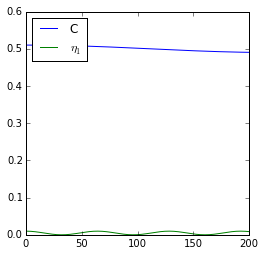

In [361]:
viewer = fp.MatplotlibViewer(vars=[C] + eta)

In [362]:
dt = .01
elapsed = 0.
saved = elapsed
duration = 10000.
step = 0

In [363]:
fp.tools.dump.write(mesh, filename="mesh.dmp")

In [364]:
fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=0))

In [365]:
with open("stats.txt", 'w') as stats:
    stats.write("\t".join(["step", "t", "dt", "Cmin", "Cmax", "f"]) + "\n")

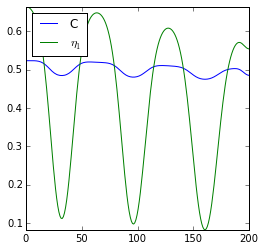

KeyboardInterrupt: 

In [366]:
while elapsed < duration:
    C.updateOld()
    for etai in eta:
        etai.updateOld()
    for sweep in range(6):
#        res = eq.sweep(dt=dt)
#        res = []
        res = [eqC.sweep(C, dt=dt)] #, solver=fp.LinearLUSolver())
        res = res + [eq_etai.sweep(etai, dt=dt) for (eq_etai, etai) in zip(eq_eta, eta)]
    print dt
    if max(res) < 0.1:
        step += 1
        elapsed += dt
        # dt *= 1.1
        viewer.plot()
        if elapsed - saved > 1:
            fp.TSVViewer(vars=[C] + eta).plot(filename="{step}.gz".format(step=step))
            # viewer.plot()
            saved = elapsed
        with open("stats.txt", 'a') as stats:
            stats.write("\t".join([str(it) for it in [step, elapsed, dt, min(C), max(C), 
                                                      f.cellVolumeAverage * mesh.cellVolumes.sum()]]) + "\n")
    else:
        dt *= 0.8
        C.value = C.old.value

In [333]:
print min(C), max(C), C.cellVolumeAverage

0.499832414316 0.500210233352 0.499996177353


In [334]:
print min(eta[0]), max(eta[0]), eta[0].cellVolumeAverage

0.0233820010764 0.0243910139848 0.0234256013481
